In [5]:
import os
import sys

sys.path.append('../')

ROOT = os.getcwd()
WORK_DIR = os.path.dirname(ROOT)

In [6]:
import numpy as np
import imageio

In [7]:
import gym
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

In [8]:
print('Observation Space: ', env.observation_space.n)
print('Sample observation ', env.observation_space.sample())

Observation Space:  16
Sample observation  13


In [9]:
print('Action Space: ', env.action_space.n)

Action Space:  4


In [10]:
print('Reward: ', env.reward_range)

Reward:  (0, 1)


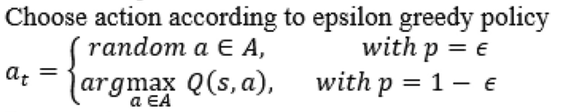

In [11]:
from PIL import Image

Image.open(os.path.join(WORK_DIR, 'images/epsilon_greedy_policy.jpg')).convert('RGB')

In [35]:
from typing import List, Any
import tqdm


class QLearning:
    
    def __init__(
        self,
        episodes: int,
        learning_rate: float,
        discount_factor: float,
        env: Any,
        max_steps: int,
        eval_seed: List[Any],
        max_epsilon: float,
        min_epsilon: float,
        decay_rate: float) -> None:
        
        self.episodes = episodes
        self.env = env
        self.max_steps = max_steps
        self.discount_factor = discount_factor
        self.eval_seed = eval_seed
        self.learning_rate = learning_rate
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
    
    def initialize_q_table(self, state_space, action_space):
        self.Qtable = np.zeros((state_space, action_space))
    
    def epsilon_greedy_policy(self, state, epsilon) -> None:
        random_int = np.random.uniform(0, 1)
        if random_int == epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Qtable[state])
        return action
    
    def get_action(self, state):
        action = np.argmax(self.Qtable[state])
        return action
    
    
    def temporary_difference(self, state, action, reward, next_state):
        return reward + self.discount_factor * np.argmax(self.Qtable[next_state]) - self.Qtable[state][action]
    
    def fit(self):
        self.initialize_q_table(
            state_space=self.env.observation_space.n,
            action_space=self.env.action_space.n
        )

        for e in tqdm.tqdm(range(self.episodes), colour='green', desc='Training Q-Table'):
            
            epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(self.decay_rate * self.episodes)
            
            state = self.env.reset()
            step = 0
            done = False
            
            for step in range(self.max_steps):
     
                action = self.epsilon_greedy_policy(state=state, epsilon=epsilon)
                
                next_state, reward, done, info = env.step(action)
                
                self.Qtable[state][action] = self.Qtable[state][action] + self.learning_rate * self.temporary_difference(state, action, reward, next_state)

                if done:
                    break
                
                state = next_state


    def predict(self):
        episode_rewards = []
        
        for e in tqdm.tqdm(range(self.episodes), colour='red', desc='Testing Q-table'):
            
            if self.eval_seed:
                state = self.env.reset(seed=self.eval_seed[e])
            
            else: 
                state = self.env.reset()
                
            step = 0
            done = False
            total_rewards_in_each_ep = 0
            
            for step in range(self.max_steps):
                
                action = self.get_action(state)
                next_state, reward, done, info = env.step(action)
                
                total_rewards_in_each_ep += reward
                
                if done:
                    break
            
                state = next_state
            
            episode_rewards.append(total_rewards_in_each_ep)
            
        env.close()
        
        return episode_rewards
    
    def render_video(self, fps: int):
        
        images = []
        done = False
        state = self.env.reset(seed=np.random.randint(0, 500))
        img = self.env.render(mode='rgb_array')
        images.append(img)
        while not done:
            action = self.get_action(state)
            
            state, reward, done, info = self.env.step(action)
            
            img = self.env.render(mode='rgb_array')
            images.append(img)
            
        imageio.mimsave('./flappy_bird.gif', [np.array(img) for img in images], fps=fps)
        

In [36]:
q_learning = QLearning(
    episodes=10000,
    learning_rate=1e-2,
    discount_factor=0.95,
    env=env,
    max_steps=99,
    eval_seed=[],
    max_epsilon=1.0,
    min_epsilon=0.05,
    decay_rate=0.0005
)

In [37]:
q_learning.fit()

Training Q-Table:   0%|          | 0/10000 [00:00<?, ?it/s]

Training Q-Table: 100%|██████████| 10000/10000 [00:19<00:00, 513.11it/s]


In [38]:
q_learning.Qtable

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
q_learning.predict()

In [ ]:
q_learning.render_video(fps=1)